# Notebook performs out_of_text tag predictions for the BR24 data set

### /data/processed_data_extra_columns.pkl is used for this notebook

### Results are saved to /data/out_of_text.pkl

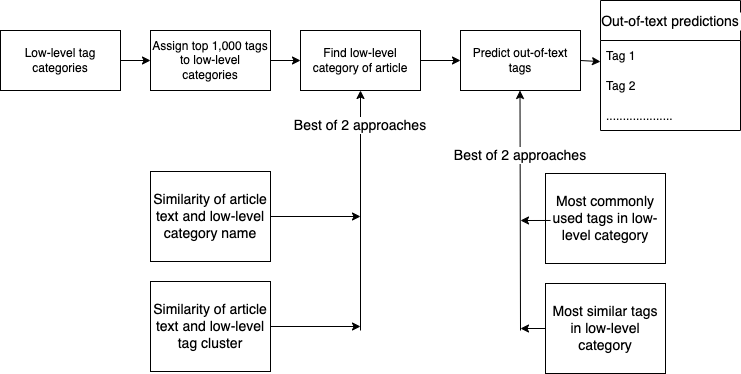

In [1]:
from IPython.display import Image

Image(filename="../images/5-out-of-text.png")

## Step 1: Create low-level tag categories
## Step 2: Pick top 1,000 tags by occurrence and assign to these low-level categories
## Step 3: Prediction

In [6]:
import pickle as pk
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas()

In [2]:
import tensorflow_hub as hub
import numpy as np
import tensorflow_text
import tensorflow as tf
import os

In [3]:
df = pd.read_pickle("../data/processed_data_extra_columns.pkl", compression='zip')

In [4]:
df.head(1)

,created_at,primary_category,share_url,row_id,tags,title,text,type,clean_text_tfidf,clean_text_tfidf_nltk_stem,clean_text_tfidf_spacy_lemma,clean_text,in_text,out_of_text,in_text_percent,out_of_text_percent
0,2021-08-05 09:44:27.368478+00:00,deutschland-welt,https://www.br.de/nachrichten/deutschland-welt...,SfClRxG,"[Ayatollah Ali Khamenei, Amtseinführung, Iran,...","Amtseinführung im Iran: Neuer Präsident, alte ...",&quot;Hier ist Bayern&quot;: Der BR24 Newslett...,TEXT,Bayern BR Newsletter informiert immer montags ...,Bay br Newslett informiert imm montag freitag ...,Bayer BR Newsletter informieren immer montags ...,"""Hier ist Bayern"": Der BR Newsletter informier...","[Ayatollah Ali Khamenei, Iran, Präsident, Ebra...",[Amtseinführung],80,20


# Out-of-text tagging

# Step 1: Create low-level categories
# Step 2: Pick top 1k tags and assign to these low-level categories

In [6]:
top_1k = dict(Counter(df['tags'].apply(pd.Series).stack()).most_common(1000))

In [7]:
top_1k.keys()

dict_keys(['Coronavirus', 'Oberbayern', 'Corona', 'Mittelfranken', 'Polizei', 'Unterfranken', 'Oberfranken', 'Niederbayern', 'Schwaben', 'Oberpfalz', 'Börse', 'Aktien', 'Fußball', 'DAX', 'Euro', 'Nürnberg', 'Corona-Krise', 'München', 'Covid-19', 'Markus Söder', 'Pandemie', 'Lockdown', 'USA', 'Feuerwehr', 'Unfall', 'Gesundheit', 'Corona-Pandemie', 'FC Bayern München', 'Regensburg', 'Wirtschaft', 'Schule', 'Coronakrise', 'Bayern', 'Würzburg', 'CSU', 'Impfung', 'Prozess', 'Bundesliga', 'Verkehr', 'Donald Trump', 'Augsburg', 'Wintersport', 'Religion', 'Kirche', 'Tourismus', 'Brand', 'Dow Jones', 'Kultur', 'Tiere', '7-Tage-Inzidenz', 'SARS-CoV-2', 'Landwirtschaft', 'Maskenpflicht', 'EU', 'Klimawandel', 'Kinder', '3. Liga', 'Justiz', '2. Bundesliga', 'Angela Merkel', 'Medizin', 'Impfstoff', 'Umwelt', 'Bamberg', 'Corona-Maßnahmen', 'Urlaub', 'Corona-Test', 'Forschung', 'Corona-Impfungen', ' Mittelfranken', 'Demonstration', 'RKI', 'Bayreuth', 'Basketball', 'Sport', 'Musik', 'Gastronomie', 'Joe

In [8]:
low_level_categories = {'Automobile' : ['Auto', 'Autoindustrie', 'Automobilindustrie', 'Automobilzulieferer',
                                        'Elektromobilität', 'Dieselskandal', 'Diesel', 'A8', 'Lkw'],
                        'Bildung' : ['Schule', 'Schulen', 'Schüler', 'Studie', 'Bildung', 'Unterricht', 'Lehrer',
                                     'Distanzunterricht', 'Ausbildung', 'Universität', 'Abitur', 'Wechselunterricht',
                                     'Hochschule', 'Studium', 'Präsenzunterricht'],
                        'Finanzen' : ['Euro', 'Nikkei', 'Deutsche Bank', 'EZB', 'Finanzen', 'Geld', 'Insolvenz',
                                      'Steuern', 'Geldpolitik', 'Bilanz', 'Banken', 'Fed', 'US-Notenbank',
                                      'Gold', 'Commerzbank', 'BaFin', 'Rente', 'Zinsen'],
                        'Elektronik' : ['Smartphone', 'Metall- und Elektroindustrie', 'Handy', 'Fans'],
                        'Fußball' : ['Fußball', 'FC Bayern München', 'Bundesliga', '3. Liga', '2. Bundesliga', 
                                     'DFB', 'Champions League', '1. FC Nürnberg', 'Hansi Flick', 'FC Augsburg',
                                     'TSV 1860 München', 'SSV Jahn Regensburg', 'Fußball-EM', 'Würzburger Kickers',
                                     'Europameisterschaft', 'SpVgg Greuther Fürth', 'FC Ingolstadt 04', 
                                     'Joachim Löw', 'DFB-Pokal', 'Türkgücü München', 'SpVgg Unterhaching',
                                     'FC Bayern München II', 'Frauenfußball', 'Thomas Müller', 'UEFA', 
                                     'FC Bayern Frauen', 'Robert Lewandowski', 'Bundestagswahl 2021', 'DFL', 
                                     'Borussia Dortmund', 'Manuel Neuer', 'Heiko Herrlich', 's.Oliver Würzburg',
                                     'Fußball-Bundesliga', 'Karl-Heinz Rummenigge', 'Regionalliga Bayern',
                                     'Fußball-Europameisterschaft', 'Rainer Koch', 'Amateurfußball', 'BFV',
                                     'Deutscher Fußball-Bund'],
                        'Gesellschaft' : ['Urlaub', 'Neustart', 'Ernährung', 'Alkohol', 'Party', 'Spenden', 'Jubiläum',
                                          'Tod', 'Müll', 'Arbeitsplätze', 'Familie', 'Ferien', 'Gesellschaft', 'Bier',
                                          'Tote', 'Ehrenamt', 'Bergwacht', 'Pflegeheim', 'Schlachthof', 'Hotel', 
                                          'Gedenken', 'Tradition', 'Wohnen', 'Sommerferien', 'Garten', 'Alkoholverbot',
                                          'Soziales', 'Freibad', 'Supermarkt', 'Trauer', 'Bauarbeiten', 'Fleisch',
                                          'Umfrage', 'Pendler', 'Architektur', 'Haushalt', 'Geburtstag', 'Ausflug', 
                                          'Neubau', 'Mode', 'Restaurant', 'Einkaufen', 'Biergarten', 'Hotels',
                                          'Essen', 'Gaststätten', 'Schließung', 'Pfingsten', 'Förderung', 
                                          'Camping', 'Armut', 'Wasserwacht', 'Unglück', 'Fleischindustrie',
                                          'Feiertag', 'Straßenbau', 'Seniorenheim', 'Senioren', 'Eltern', 'Altenheim',
                                          'Altenpflege', 'Fische'],
                        'Gesundheit' : ['Gesundheit', 'Medizin', 'Krankenhaus', 'Pflege', 'Gesundheitsministerium',
                                        'Drogen', 'Infektionsschutzgesetz', 'Gesundheitsamt', 'Intensivstation',
                                        'Fitnessmagazin', 'Trinkwasser', 'Klinik', 'Verletzte', 'Krankheit', 'Ärzte',
                                        'Pflegekräfte', 'Ansteckung', 'Medikamente', 'Krebs', 'Hotspots', 'WHO', 
                                        'Krankenhäuser', 'Hygienevorschriften', 'LGL', 'Lothar Wieler', 'Klinikum', 
                                        'Geburt', 'Hausärzte', 'Geflügelpest', 'Depression', 'Aerosole', 'Arzt',
                                        'Grippe', 'Stiko', 'Apotheke', 'Patienten', 'Vogelgrippe', 'Impfung', 'RKI', 
                                        'Robert-Koch-Institut', 'Infektion', 'Präsenzunterricht',
                                        'Robert Koch-Institut'],
                        'Justiz' : ['Justiz', 'Hof', 'Urteil', 'Kriminalität', 'Staatsanwaltschaft', 'Gericht',
                                    'Missbrauch', 'Sexueller Missbrauch', 'Landratsamt', 'Klage', 'Landgericht', 
                                    'Bayerischer Verwaltungsgerichtshof', 'Bundesverfassungsgericht',
                                    'Maskenaffäre', 'Bundesgerichtshof', 'BGH'],
                        'Polizei' : ['Kriminalität', 'Gericht', 'Sexueller Missbrauch'],
                        'Katastrophe' : ['Brand', 'Hochwasser', 'Verkehrsunfall', 'Unwetter', 'Überschwemmungen',
                                         'Gewitter', 'Hochwasserschutz', 'Sachschaden'],
                        'Kinder' : ['Kinder', 'Jugendliche', 'Kita', 'Grundschule', 'Kindergarten', 'Kindesmissbrauch',
                                    'Kitas', 'Baby', 'Kinderpornografie', 'Kinderbetreuung'],
                        'Konjunktur' : ['Verdi', 'Arbeitsmarkt', 'Baustelle', 'Arbeit', 'Konjunktor', 
                                        'Konjunktur', 'Arbeitslosigkeit',
                                        'Mieten', 'BIP', 'Inflation', 'Versicherung', 'Deutsche Post', 'Startup', 'Zoll',
                                        'Arbeitslosenzahlen', 'Start-Up', 'Konjunktursorgen', 'Verbraucherschutz',
                                        'Konjunkturpaket'],
                        'Kultur' : ['Tourismus', 'Kultur', 'Kino', 'Gastronomie', 'Musik', 'Kunst', 'Weihnachten',
                                    'Literatur', 'Film', 'Theater', 'Reisen', 'Ausstellung', 'Freizeit', 'Museum',
                                    'Geschichte', 'kinokino', 'Wandern', 'Lebensmittel', 'Kontrovers', 'Oktoberfest',
                                    'Film und Serie', 'Kritik', 'Handwerk', 'Künstler', 'George Floyd', 'Silvester',
                                    'Volksfest', 'Zuschauer', 'Buch', 'Hollywood', 'Konzert', 'Festival', 'Oper',
                                    'Albumkritik', 'Schauspieler', 'Fasching', 'Auszeichnung', 'Schausteller',
                                    'Reisewarnung', 'Dehoga', 'Kabarett', 'Bücher', 'Pop', 'Lesen', 'Kulturhauptstadt',
                                    'Album', 'Richard Wagner', 'Öffnung', 'Veranstaltungen', 'Kultusministerium'],
                        'Landwirtschaft' : ['Landwirtschaft', 'Weiden', 'Bauern', 'Landwirte', 'Erntehelfer'],
                        'Nachrichten' : ['Rundschau', 'Bayern 2', '#faktenfuchs', 'Bayernthema', 'radioWelt', 'Medien',
                                         '#Faktenfuchs', 'B5 aktuell', 'Tagesgespräch', 'ARD', 'Fernsehen', 'BR24Live', 
                                         'Sternstunden', 'Possoch klärt', 'Journalismus', 'Podcast', 'mehr/wert', 
                                         'ZDF', 'Pressefreiheit', 'ARD-WIEN', 'Tagesschau', 'ARD-alpha', 'STATIONEN'],
                        'Netzwelt' : ['Facebook', 'Internet', 'Datenschutz', 'Twitter', 'Instagram', 'App', 'Social Media',
                                      'Streaming', 'Bitcoin', 'TikTok', 'Fake News', 'Netflix', 'Soziale Netzwerke',
                                      'Youtube', 'WhatsApp', 'Online', 'Soziale Medien', 'Mobilfunk'],
                        'Personen' : ['Demonstration', 'Flüchtlinge', 'Rassismus', 'Protest', 'Streik', 'Warnstreik', 'Antisemitismus',
                                      'Verschwörungstheorien', 'Frauen', 'Ausgangssperre', 'Proteste', 'Zweiter Weltkrieg', 
                                      'Streit', 'Anschlag', 'Querdenken', 'Demokratie', 'Juden', 'BRK', 'Migration', 'Flucht',
                                      'Hilfe', 'Asylbewerber', 'Holocaust', 'Homosexualität', 'Diskriminierung',
                                      'Körperverletzung', 'Petition', 'Integration', 'Menschen mit Behinderung', 
                                      'Inklusion', 'Demonstrationen', 'Black Lives Matter', 'Migranten', 'Abschiebung',
                                      'Gleichberechtigung', 'Kundgebung', 'Bürgerinitiative', 'Menschenrechte', 'Absage',
                                      'Hubschrauber', 'Caritas', 'Geflüchtete', 'Seenotrettung', 'Terrorismus', 
                                      'Rettungskräfte', 'Rettungshubschrauber', 'Bayerisches Rotes Kreuz', 'Obdachlose', 
                                      'Nationalsozialismus'],
                        'Politik' : ['Markus Söder', 'CSU', 'Donald Trump', 'Angela Merkel', 'SPD', 'Joe Biden',
                                     'Bundestagswahl', 'Grüne', 'Jens Spahn', 'Freie Wähler', 'AfD', 'CDU', 
                                     'Hubert Aiwanger', 'Politik', 'Rechtsextremismus', 'FDP', 'Bundestag', 'Armin Laschet',
                                     'Michael Piazolo', 'Landtag', 'Klaus Holetschek', 'Horst Seehofer', 'Joachim Herrmann',
                                     'Nationalsozialismus', 'Brexit', 'Olaf Scholz', 'US-Wahl', 'Melanie Huml', 
                                     'Kanzlerkandidatur', 'Bernd Sibler', 'Kultusministerium', 'Wahl', 
                                     'Bayerischer Landtag', 'Alexej Nawalny', 'Boris Johnson', 'US-Präsidentschaftswahl', 
                                     'CDU/CSU', 'Die Grünen', 'Andreas Scheuer', 'Verfassungsschutz', 'Annalena Baerbock',
                                     'Dieter Reiter', 'US-Präsident', 'Parteitag', 'Annegret Kramp-Karrenbauer', 
                                     'Heiko Maas', 'Wladimir Putin', 'Ursula von der Leyen', 'Alexander Lukaschenko',
                                     'Sebastian Kurz', 'Wahlkampf', 'Frank-Walter Steinmeier', 'Bündnis 90/Die Grünen',
                                     'Linke', 'Kommunalwahl', 'Peter Altmaier', 'Hubertus Heil', 'Thorsten Glauber', 
                                     'Kommunalpolitik', 'Karl Lauterbach', 'Münchner Runde', 'Robert Habeck',
                                     'Kommentar', 'NSU', 'Opposition', 'Benjamin Netanjahu', 'Die Linke', 
                                     'Friedrich Merz', 'Julia Klöckner', 'Präsidentschaftswahl', 'Heinz-Peter Meidinger',
                                     'Kabinett', 'US-Wahlkampf', 'Emmanuel Macron'],
                        'Polizei' : ['Polizei', 'Polizeimeldung', 'Mord', 'Gewalt', 'Ermittlungen', 'Betrug', 'Fahndung',
                                     'Messerattacke', 'Festnahme', 'Bundespolizei', 'Diebstahl', 'Terror', 'Mordprozess', 
                                     'Vergewaltigung', 'Polizeieinsatz', 'Kriminalpolizei', 'Polizeigewalt', 
                                     'Brandstiftung', 'Kripo', 'Fliegerbombe', 'Totschlag', 'Einbruch', 'Angriff', 
                                     'Zeugen', 'Großeinsatz', 'Vermisstensuche', 'Gefängnis', 'Hacker', 'Vermisste', 
                                     'Messerangriff', 'Hackerangriff', 'Cybercrime', 'Tötungsdelikt', 'Schleuser',
                                     'Schlägerei'],
                        'Regierung' : ['Prozess', 'Stadtrat', 'Bundesregierung', 'Bundeswehr', 'Grenze', 'Grenzkontrollen',
                                       'Staatsregierung', 'Sanierung', 'Ausgangsbeschränkung', 'Kontaktbeschränkungen',
                                       'Oberbürgermeister', 'Sicherheit', 'Kommunen', 'Bürgermeister', 'Bürgerentscheid',
                                       'Bußgeld', 'Kontrollen', 'Sperrung', 'IHK', 'Rathaus', 'Verwaltungsgericht',
                                       'Denkmalschutz', 'Öffentlicher Dienst', 'Korruption', 'Razzia', 'Waffen', 
                                       'Landrat', 'Militär', 'Untersuchungsausschuss', 'THW', 'LGL',
                                       'Landesamt für Gesundheit und Lebensmittelsicherheit', 'Truppenabzug', 'NATO', 'Zollstreit'],
                        'Religion' : ['Religion', 'Kirche', 'Katholische Kirche', 'Evangelische Kirche', 'Glaube',
                                      'Gottesdienst', 'Judentum', 'Islam', 'Papst Franziskus', 'Muslime', 'Papst', 
                                      'Synagoge'],
                        'Sport' : ['Sport', 'Basketball', 'Nationalmannschaft', 'BBL', 'Olympia', 'FC Bayern Basketball',
                                   'Basketball-Bundesliga', 'Brose Bamberg', 'Olympische Spiele', 'Tokio 2020',
                                   'Tennis', 'Schwimmen', 'Radsport', 'medi bayreuth', 'Formel 1', 'Handball', 'Motorsport',
                                   'Transfer', 'Breitensport', 'Schwimmbad', 'Blickpunkt Sport', 'Markus Eisenbichler', 
                                   'Gymnasium', 'Geisterspiele', 'Karl Geiger', 'Doping', 'Sebastian Vettel'],
                        'Tierwelt' : ['Tiere', 'Tierschutz', 'Artenschutz', 'Hunde', 'Vögel', 'Wildtiere', 
                                      'Landesbund für Vogelschutz', 'Wolf', 'Bienen', 'Zoo', 'Haustiere', 'Pferde', 
                                      'Tierheim', 'Schweine', 'Tierwohl', 'Bund Naturschutz'],
                        'Transport' : ['Verkehr', 'Bahn', 'Autobahn', 'Fahrrad', 'ÖPNV', 'Deutsche Bahn',
                                       'A3', 'Mobilität', 'Motorrad', 'Stau', 'A9', 'Flughafen', 'Nahverkehr',
                                       'Bus', 'Bahnhof', 'Öffentlicher Nahverkehr', 'Flugverkehr', 'Radfahrer',
                                       'S-Bahn', 'Zug', 'Fahrradfahrer', 'Lastwagen', 'Flugzeug', 'Motorradfahrer',
                                       'Straßenverkehr', 'ICE'],
                        'Umwelt' : ['Klimawandel', 'Wald', 'Umwelt', 'Klimaschutz', 'Naturschutz', 'Wetter', 'Natur', 'Umweltschutz',
                                    'Bayerischer Wald', 'Schnee', 'Winter', 'Regen', 'Sommer', 'Bund Naturschutz',
                                    'Starkregen', 'Wasser', 'Klima', 'Hitze', 'Trockenheit', 'Fridays for Future', 'LBV', 
                                    'Berge', 'Wiesn', 'Insekten', 'Bäume', 'Artenvielfalt', 'Pflanzen', 'Erderwärmung',
                                    'Deutscher Wetterdienst', 'Fluss', 'Hagel', 'Ökologie', 'Treibhausgase'],
                        'Unfall' : ['Feuerwehr', 'Unfall', 'Feuer', 'tödlicher Unfall', 'Explosion', 'Raser',
                                    'Evakuierung', 'Rettung', 'Unfälle', 'Notbremse', 'Badeunfall', 'Sachschaden'],
                        'Wintersport' : ['Wintersport', 'Ski Alpin', 'Eishockey', 'Biathlon', 'Skispringen', 
                                         'DEL', 'Deutsche Eishockey-Liga', 'Skifahren', 'Straubing Tigers',
                                         'Rodeln', 'Langlauf'],
                        'Wirtschaft' : ['Wirtschaft', 'Einzelhandel', 'IG Metall', 'Gewerkschaft', 'Union', 
                                        'Kurzarbeit', 'Handelskonflikt', 'Stellenabbau', 'Nachhaltigkeit',
                                        'Tarifverhandlungen', 'Ölpreis', 'Handel', 'Handelsstreit', 'Verbraucher',
                                        'Immobilien', 'Wirtschaftswachstum', 'Brauchtum', 'Industrie', 'Brauerei',
                                        'Online-Handel', 'Holz', 'Geschäfte', 'DGB'],
                        'Wissen' : ['Datenschutz', 'Forschung', 'Wissenschaft', 'Digitalisierung', 
                                    'Energiewende', 'Weltraum', 'Energie', 'Raumfahrt', 'CO2', 'Astronomie', 
                                    'Faktencheck', 'Luftfahrt', 'Archäologie', 'Statistik', 
                                    'Künstliche Intelligenz', 'Psychologie', 'Strom', 'Windkraft', 
                                    'Erneuerbare Energien', 'Atomkraft', 'ifo-Institut', 'Wasserstoff',
                                    'Treibhausgase', 'Atommüll', 'Weltall', 'Photovoltaik', 'NASA'],
                        'Coronavirus' : ['Coronavirus', 'Corona', 'Corona-Krise', 'Covid-19', 'Pandemie', 
                                         'Lockdown', 'Coronakrise', 'Corona-Pandemie', 'RKI', 'Robert-Koch-Institut',
                                         'Impfung', 'SARS-CoV-2', 'Maskenpflicht', '7-Tage-Inzidenz', 'Impfstoff',
                                         'Corona-Maßnahmen', 'Corona-Test', 'Corona-Impfungen',
                                         'Corona-Impfstoff', 'Quarantäne', 'Neuinfektionen', 'Lockerungen',
                                         'Liveticker', 'Impfzentrum', 'Inzidenzwert', 'Biontech', 
                                         'Corona-Mutation', 'Infektion', 'Homeoffice','Homeschooling', 
                                         'AstraZeneca', 'Schnelltest', 'FFP2-Masken', 'Sieben-Tage-Inzidenz', 
                                         'Corona-Regeln', 'Corona-Lockerungen', 'Mund-Nasen-Masken'
                                         'Ausgangssperre', 'Teil-Lockdown', 'Coronatest', 'Ausgangsbeschränkung',
                                         'Corona-Virus', 'Corona-Warn-App', 'Kontaktbeschränkungen','Testpflicht', 
                                         'Intensivstation', 'Hygienekonzept', 'Virus', 'Präsenzunterricht', 
                                         'Robert Koch-Institut','Hygiene', 'Infektionszahlen', 'Robert Koch-Institut',
                                         'Reiserückkehrer', 'Abstandsregelung', 'Masken', 'Moderna', 
                                         'Querdenken','Todesfälle', 'Astrazeneca', 'R-Wert', 'Risikogebiet', 
                                         'Corona-Auflagen', 'Intensivbetten', 'Delta-Variante', 'Corona-Impfung', 
                                         'Pfizer', 'Test', 'Mund-Nasen-Schutz', 'PCR-Test', 'Corona-App', 
                                         'Infektionsschutz', 'Corona-Demo', 'Corona-Teststation', 'Impfpflicht', 
                                         'Impfzentren, ''Sars-CoV-2-Virus', 'Corona-Schnelltest'],
                        'Börse' : ['Börse', 'Aktien', 'DAX', 'Euro', 'Dow Jones', 'MDAX', 'Nasdaq', 'B5 Börse', 'Wall Street', 'Nikkei']}

In [9]:
low_level_categories.keys()

dict_keys(['Automobile', 'Bildung', 'Finanzen', 'Elektronik', 'Fußball', 'Gesellschaft', 'Gesundheit', 'Justiz', 'Polizei', 'Katastrophe', 'Kinder', 'Konjunktur', 'Kultur', 'Landwirtschaft', 'Nachrichten', 'Netzwelt', 'Personen', 'Politik', 'Regierung', 'Religion', 'Sport', 'Tierwelt', 'Transport', 'Umwelt', 'Unfall', 'Wintersport', 'Wirtschaft', 'Wissen', 'Coronavirus', 'Börse'])

In [10]:
len(low_level_categories.keys())

30

# Step 3: Making predictions

## This stage is divided into two steps:

### 1. Predict low-level category of the article
#### a. Using embedding similarity of article text and low-level category name
#### b. Using embedding similarity of article text and low-level tag cluster
### 2. Predict tags for the article depending on the low-level category tags
#### a. 10 ‘most commonly used tags’ in the low-level category
#### b. 10 ‘most similar tags’, from low-level category


#### Process 2a which predicts the top 10 ’most commonly used tags’ after finding the low-level category of an article is not very promising. This step would restrict the top 1,000 tags distributed over 30 categories, to only 300 tags, 10 for each category. And will always predict the same set of tags for a particular category, unless the tag dictionary is updated. Therefore, we do not consider this step in our prediction approach.

## Therefore we now have two approaches combining both steps, 
## - Approach 1 : Step 1a followed by Step 2b
## - Approach 2 : Step 1b followed by Step 2b

# Approach 1

# Step 1a: Predict low-level category of the article using embedding similarity of article text and low-level category name

In [11]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

In [11]:
categories_embedding_1 = embed(list(low_level_categories.keys())).numpy()

def predict_category_step_1a(row):
    """
    Function takes an article and returns a list of 3 low-level categories for that article following below steps:
    1. Embeddings of the low-level category names are calculated only once
    2. Embed the text of the article
    3. Calculate distance between the text embedding and low-level category name embeddings
    4. Order these distances and accordingly the indices of the low-level categories in the dictionary
    5. Collect top 3 low-level categories with the closest distance to the article embeddings
    
    :param row: one row of the dataframe
    :return: list of top 3 categories for the article
    """
    
    article_embedding = embed(row.clean_text[:20000]).numpy()
    
    distances = np.dot(article_embedding, np.transpose(categories_embedding_1))[0]
    category_indices = distances.argsort()[-3:][::-1]

    categories = [list(low_level_categories)[c] for c in category_indices]

    return categories

In [12]:
df['approach_1_step_1a'] = df.progress_apply(predict_category_step_1a, axis=1)

100%|██████████| 40862/40862 [1:47:33<00:00,  6.33it/s]  


# Step 2b: Predict 10 ‘most similar tags’ for the article depending on the low-level category tags

In [ ]:
def predict_tags_step_2b(text, tag_list):
    """
    Function takes an article text and a tag_list composed of tags in the predicted top 3 low-level categories.
    It returns 10 most similar tags from the list depending on the article text, following the below steps:
    1. Embed the text of the article
    2. Embed the tags in the tag_list
    3. Calculate distance between the text embedding and tag embeddings
    4. Order these distances 
    5. Collect top 10 tags which are closest to the article embeddings
    
    :param text: article text
    :param tag_list: list of tags in the top 3 low-level categories
    :return: list of top 10 most similar tags for the article
    """
    
    article_embedding = embed(text[:20000]).numpy()
    tag_embedding = embed(tag_list).numpy()
    
    distances = np.dot(tag_embedding, article_embedding.reshape(-1,1))
    zipped = zip(distances, tag_list)
    sorted_zipped = sorted(zipped, key = lambda t: t[0])
    tags = list(list(zip(*sorted_zipped[-10:]))[1:][0])
    tags.reverse()
        
    return tags

In [13]:
df['approach_1_step_2b'] = df.progress_apply(lambda x: predict_tags_step_2b(x['clean_text'], low_level_categories[x['approach_1_step_1a'][0]]+low_level_categories[x['approach_1_step_1a'][1]]+low_level_categories[x['approach_1_step_1a'][2]]), axis=1)

100%|██████████| 40862/40862 [2:43:51<00:00,  4.16it/s]  


# Find matches

In [15]:
import difflib

In [16]:
def find_matches(truth, predictions):
    """
    Function compares the truth value (editor tags) and predictions made by the system using the difflib library.
    1. A prediction is considered as a match if it a close match and scores at least 0.7 with an editor tag using the difflib.get_close_matches
    2. If no match is found then we look for a substring match.
    
    If both steps do not give a match, then there is no prediction for that particular editor tag.
    
    :param truth: editor tags
    :param predictions: predictions made by the system
    :return: those predictions which are correct, i.e., match with editor predictions
    """
    
    matches = []
    for tag in truth:
        predicted = difflib.get_close_matches(tag, predictions, 1, 0.7) #closest match
        if not predicted:
            predicted = [key for key in predictions if tag in key] #if no closest match then take substring match
        
        if predicted:
            matches.append(predicted[0])
        else:
            continue
    return matches

# Find matches of Approach 1 with out_of_text tags

In [18]:
df['approach_1_x_out_of_text'] = df.progress_apply(lambda x: find_matches(x['out_of_text'], x['approach_1_step_2b']), axis=1)

100%|██████████| 40862/40862 [00:05<00:00, 8038.43it/s]


In [4]:
approach_1_x_out_of_text_acc = df.apply(lambda row: int(((len(row.approach_1_x_out_of_text)/len(row.out_of_text) if len(row.out_of_text) != 0 else -1 ))*100), axis=1)

In [5]:
print((approach_1_x_out_of_text_acc).mean())

6.322720375899369


# Approach 2

# Step 1b: Predict low-level category of the article using embedding similarity of article text and low-level tag cluster

In [14]:
# Calculate the embeddings of the low-level tag cluster for all low-level categories in the dictionary

categories_embedding_2 = np.zeros(shape=(30,512)) # initialize with zeroes

for idx, c in enumerate(list(low_level_categories.keys())): 
    category_embeddings = embed(c) # embedding of the low-level category name
    value_embeddings = np.mean(embed(low_level_categories[c]), axis=0) # mean of embedding of all tags in the low-level category
    cluster_embeddings = (np.array(category_embeddings) + np.array(value_embeddings)) / 2 # mean of embeddings of the low-level category name and the tags in the category
    categories_embedding_2[idx] = cluster_embeddings

In [ ]:
def predict_category_step_1b(row):
    """
    Function takes an article and returns a list of 3 low-level categories for that article following below steps:
    1. Embeddings of the low-level tag cluster are calculated only once
    2. Embed the text of the article
    3. Calculate distance between the text embedding and low-level tag cluster embeddings
    4. Order these distances
    5. Collect top 3 low-level categories with the closest distance to the article embeddings
    
    :param row: one row of the dataframe
    :return: list of top 3 categories for the article
    """
    
    article_embedding = embed(row.clean_text[:20000]).numpy()
    
    distances = np.dot(article_embedding, np.transpose(categories_embedding_2))[0]
    category_indices = distances.argsort()[-3:][::-1]

    categories = [list(low_level_categories)[c] for c in category_indices]

    return categories

In [15]:
df['approach_2_step_1b'] = df.progress_apply(predict_llc_app_3, axis=1)

100%|██████████| 40862/40862 [1:46:26<00:00,  6.40it/s]  


# Step 2b: Predict 10 ‘most similar tags’ for the article depending on the low-level category tags

In [ ]:
# As this step is same as in approach 1 we re-use the function 'predict_tags_step_2b'

In [33]:
df['approach_2_step_2b'] = df.progress_apply(lambda x: predict_tags_step_2b(x['clean_text'], low_level_categories[x['approach_2_step_1b'][0]]+low_level_categories[x['approach_2_step_1b'][1]]+low_level_categories[x['approach_2_step_1b'][2]]), axis=1)

100%|██████████| 40862/40862 [2:42:26<00:00,  4.19it/s]  


# Find matches of Approach 2 with out_of_text tags

In [40]:
df['approach_2_x_out_of_text'] = df.progress_apply(lambda x: find_matches(x['out_of_text'], x['approach_2_step_2b']), axis=1)

100%|██████████| 40862/40862 [00:05<00:00, 7683.37it/s]


In [7]:
approach_2_x_out_of_text_acc = df.apply(lambda row: int(((len(row.approach_2_x_out_of_text)/len(row.out_of_text) if len(row.out_of_text) != 0 else -1 ))*100), axis=1)

In [8]:
print(approach_2_x_out_of_text_acc[approach_2_x_out_of_text_acc >= 0].mean())

14.741446468049269


In [ ]:
df = df.drop(['clean_text_tfidf', 'clean_text_tfidf_nltk_stem', 'clean_text_tfidf_spacy_lemma', 'in_text_percent', 'out_of_text_percent'], axis=1) # dropping other irrelevant columns

In [51]:
df.to_pickle('./data/out_of_text.pkl', compression='zip')